In [32]:
# clear modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import sys
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # silence warning logs
singularity_name = os.environ.get("SINGULARITY_NAME")
if singularity_name: print("Singularity:\t", singularity_name)    
print("version_info:\t", sys.version_info)
print("executable:\t",sys.executable)
print("pwd:\t\t", os.getcwd())

Singularity:	 TensorFlow:25.02-tf2-py3.SIF
version_info:	 sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
executable:	 /usr/bin/python
pwd:		 /auto/brno2/home/romova9/2D_to_3D


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import ndnoise
import random
from numbers import Number
from typing import Optional
from pathlib import Path
import scipy
import cv2
import skimage.transform
import nibabel
import h5py
import json

from PIL import Image
from loguru import logger
import io3d
import io3d.datasets
logger.enable("io3d")
logger.disable("io3d")

from methods_2D import image_generator_train_deepvesselnet, image_generator_train_3DIrcad, image_generator_train_Pigs

# Data

In [35]:
# Zvol task, vpřípadě potřeby uprav trénovací ids a typ úlohy
tasks = ["Deepvesselnet", "3DIrcad", "Pigs"]
axis = ["axial","coronal","sagital"]
smooth = 1

task = 2

In [36]:
def datagenerator_train(task=2, batchsize=2, shape=(256, 256), axis_index=0):
    '''
    Generuje data pro trénování podle zadané úlohy v náhodném pořadí.
    axis_index - určuje v jakém pohledu mají být data řezána [axial, sagittal, coronal]
    '''
    if task == 0:
        directory = 'data/deepvesselnet/seg'
        all_dirs = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        ct_ids_train, ct_ids_test = split_files(all_dirs, train_ratio=0.8)

        train_generator = image_generator_train_deepvesselnet(ct_ids_train, batch_size=batchsize, sz=shape, axis=axis_index)
        test_generator  = image_generator_train_deepvesselnet(ct_ids_test, batch_size=batchsize, sz=shape, axis=axis_index)

    elif task == 1:
        io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["_"] = "data/medical/orig/3Dircadb1/3Dircadb1.{id}/MASKS_DICOM/{data_type}/"
        io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["data3d"] = "data/medical/orig/3Dircadb1/3Dircadb1.{id}/PATIENT_DICOM/"
        io3d.datasets.get_dataset_path("3Dircadb1", "data3d", 1)
        
        promenne = s_artery
        ct_ids_train = [1, 6, 7, 8, 9, 11, 12, 13, 17]
        ct_ids_test = [14, 5]

        train_generator = image_generator_train_3DIrcad(ct_ids_train, promenne=promenne, batch_size=batchsize, sz=shape, axis=axis_index)
        test_generator  = image_generator_train_3DIrcad(ct_ids_test, promenne=promenne, batch_size=batchsize, sz=shape, axis=axis_index)

    elif task == 2:
        directory = "data/pilsen_pigs"
        ct_ids_train = ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven',
                        'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art',
                        'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']
        ct_ids_test = ['Tx021D_Ven', 'Tx040D_Art']

        train_generator = image_generator_train_Pigs(ct_ids_train, batch_size=batchsize, sz=shape, axis=axis_index)
        test_generator  = image_generator_train_Pigs(ct_ids_test, batch_size=batchsize, sz=shape, axis=axis_index)

    else:
        print("Nastala chyba při generování dat!")
        return None, None

    return train_generator, test_generator, ct_ids_train, ct_ids_test

In [37]:
train_generator, test_generator, ct_ids_train, ct_ids_test = datagenerator_train(task=task, batchsize=2, shape=(256, 256), axis_index=0)

train_x, train_y = next(train_generator)
test_x, test_y = next(test_generator)

In [38]:
print(np.min(train_x), np.max(train_x), len(np.unique(train_x)))
print(np.min(train_y), np.max(train_y), len(np.unique(train_y)))
print(np.min(test_x), np.max(test_x), len(np.unique(test_x)))
print(np.min(test_y), np.max(test_y), len(np.unique(test_y)))
print()
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

0.0 1.0 194953
0.0 1.0 2
0.0 1.0 193335
0.0 1.0 2

(2, 256, 256, 3) (2, 256, 256, 2)
(2, 256, 256, 3) (2, 256, 256, 2)


# Predict

In [39]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Num GPUs Available:  2


In [40]:
from tensorflow.keras import backend as K
from tensorflow.keras import Model, layers, mixed_precision
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Activation, Concatenate, BatchNormalization
#from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal

In [ ]:
import pandas as pd
# Dictionary to collect results
# Format: {metric_name: {model_name: evaluation_value, ...}, ...}
results_dict = {}
axis = ["axial","coronal","sagital"]
modely = []
for ax in axis:
    # text = promene[0] + "_" + ax
    # text = "pilsen_pigs" + "_" + ax
    text = "pilsen_pigs_weight_" + ax
    
    with strategy.scope():
        # Define custom objects
        custom_objects = {
            "dice_coef": dice_coef,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score
        }
        
        # Load the model with custom objects
        model = tf.keras.models.load_model("model_final/" + text + '_12.h5', custom_objects=custom_objects)
    
    modely.append(model)
    
    # Prepare the data generators
    train_generator, test_generator, ct_ids_train, ct_ids_test = datagenerator_train(task=task, batchsize=2, shape=(256, 256), axis_index=0)
    
    # Calculate steps per epoch (using batch_size; adjust if needed)
    batch_size = 5
    avg_slice_number = batch_size  
    train_steps = (avg_slice_number * len(ct_ids_train)) // batch_size
    test_steps = (avg_slice_number * len(ct_ids_test)) // batch_size
    
    # Evaluate the model
    evaluation = model.evaluate(
        test_generator,
        steps=test_steps,  
        verbose=1  
    )
    
    # Get metric names from the model
    metric_names = model.metrics_names  # e.g., ['loss', 'iou_background', ...]
    
    # Collect results for each metric
    for m, v in zip(metric_names, evaluation):
        if m not in results_dict:
            results_dict[m] = {}
        results_dict[m][text] = v

# Create a DataFrame with metrics as rows and model names as columns
metrics_df = pd.DataFrame(results_dict).transpose()
print("Summary of all models:")
print(metrics_df)

# Each model

In [ ]:
batch_size = 512

x_axial, y_axial = next(image_generator_train(ct_ids_test, batch_size=32, sz=(256, 256), axis=0))
x_coronal, y_coronal = next(image_generator_train(ct_ids_test, batch_size=32, sz=(256, 256), axis=1))
x_sagital, y_sagital = next(image_generator_train(ct_ids_test, batch_size=32, sz=(256, 256), axis=2))

print(x_axial.shape, y_axial.shape)
print(x_coronal.shape, y_coronal.shape)
print(x_sagital.shape, y_sagital.shape)

x = [x_axial, x_coronal, x_sagital]
y = [y_axial, y_coronal, y_sagital]

In [ ]:
predpovedi = []
for i in range(3):
    print(axis[i])
    vyhodnoceni = modely[i].evaluate(x=x[i], y=y[i])
    predpovedi.append(modely[i].predict(x=x[i]))
    print(predpovedi[-1].shape)

for a in range(3):
    predpovedi[a][predpovedi[a]>=0.5] = 2
    predpovedi[a][predpovedi[a]<0.5] = 0
    predpovedi[a][predpovedi[a]==2] = 1

axial


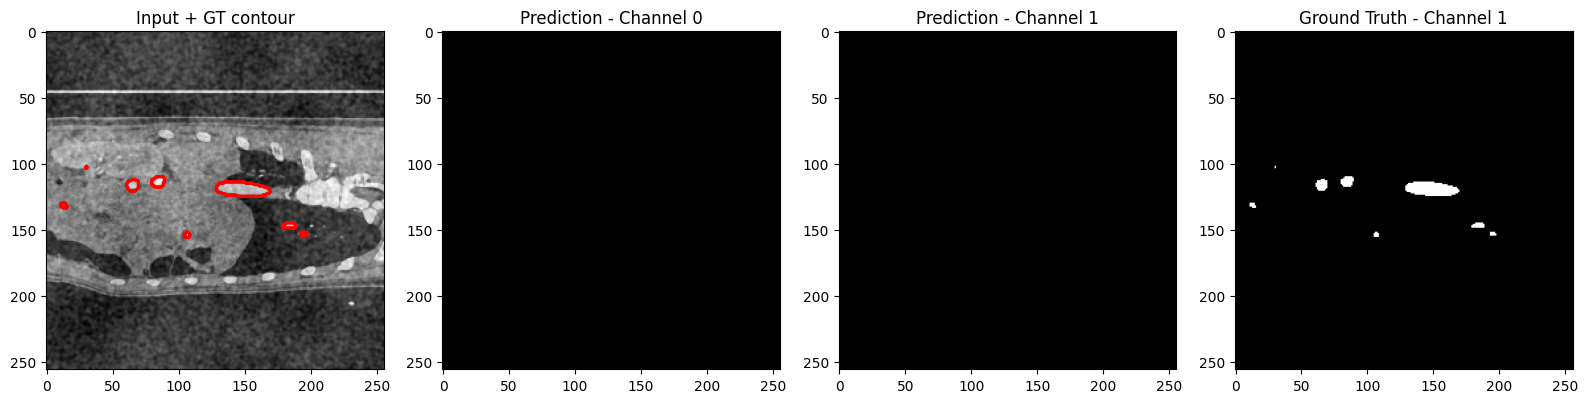

coronal


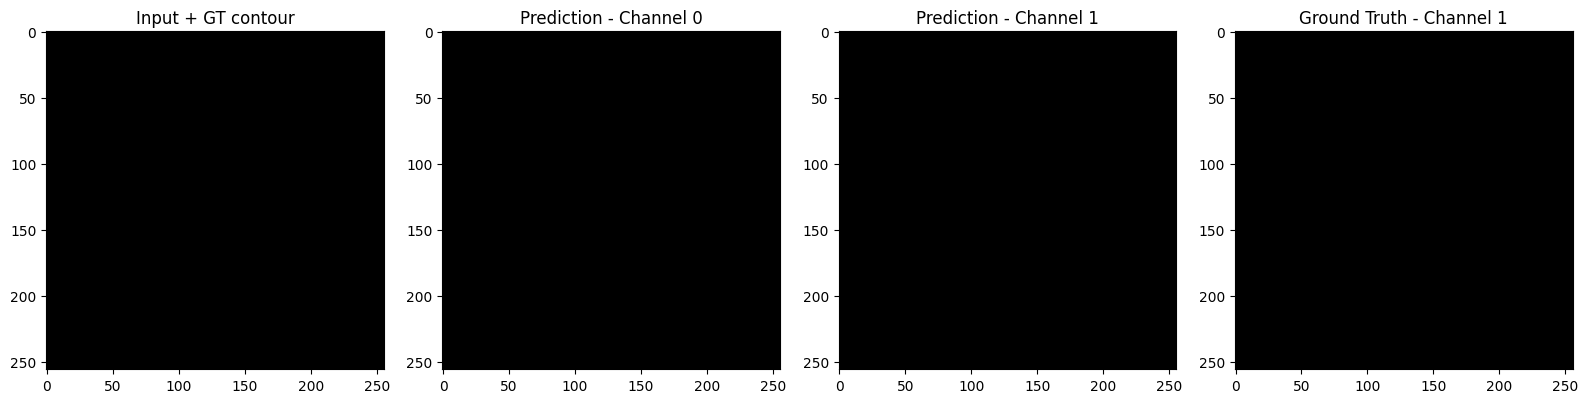

sagital


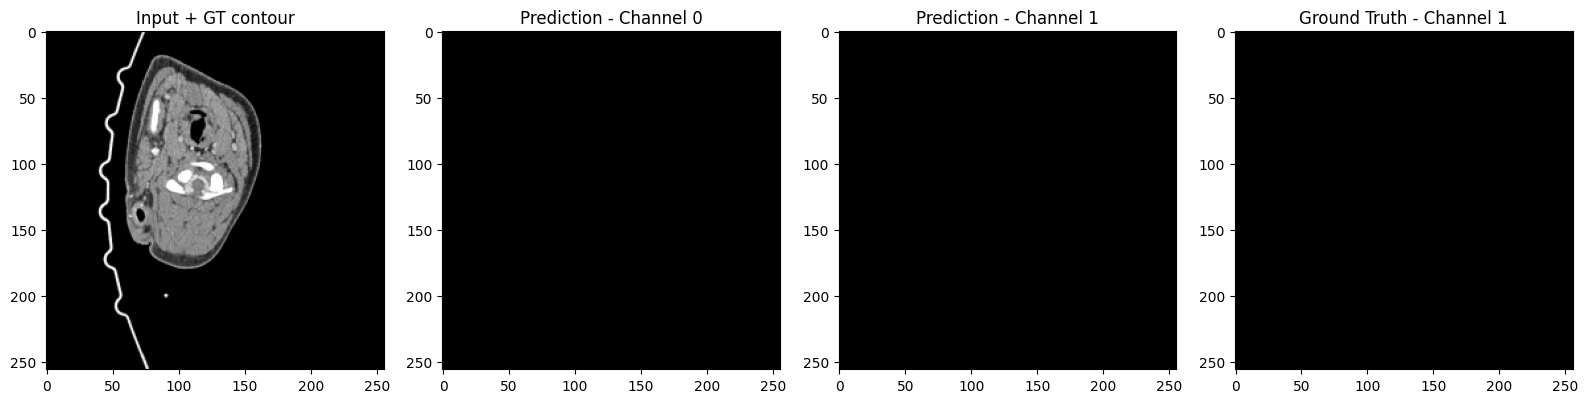

In [31]:
slice_ = [30,30,30]

for i in range(3):
    print(axis[i])  

    plt.figure(figsize=(16, 4))  # width=16 inches, height=4 inches

    plt.subplot(1, 4, 1)
    plt.imshow(x[i][slice_[i], :, :, 0], cmap="gray")
    plt.contour(y[i][slice_[i], :, :, 0], colors="red")
    plt.title("Input + GT contour")

    plt.subplot(1, 4, 2)
    plt.imshow(predpovedi[i][slice_[i], :, :, 0], cmap="gray")
    plt.title("Prediction - Channel 0")

    plt.subplot(1, 4, 3)
    plt.imshow(predpovedi[i][slice_[i], :, :, 1], cmap="gray")
    plt.title("Prediction - Channel 1")

    plt.subplot(1, 4, 4)
    plt.imshow(y[i][slice_[i], :, :, 1], cmap="gray")
    plt.title("Ground Truth - Channel 1")

    plt.tight_layout()
    plt.show()

# Concrete CT

In [ ]:
import numpy as np
import nibabel as nib
import tensorflow as tf
from skimage.transform import resize
from scipy.ndimage import zoom

def resample_to_voxelsize(volume, spacing, target_spacing=(1.0, 1.0, 1.0), order=3):
    """Resample volume to target voxel spacing using scipy zoom."""
    resize_factors = np.array(spacing) / np.array(target_spacing)
    return zoom(volume, resize_factors, order=order)

def apply_models_on_nifti(nifti_path, models):
    """
    Apply 3-axis AI models to a 3D NIfTI image and return the raw, mask, and prediction.

    Parameters:
        nifti_path (str): Path to the input NIfTI file.
        models (list): List of 3 TensorFlow models [axial, coronal, sagittal].

    Returns:
        raw (np.ndarray): The normalized, windowed 3D input volume with shape (Z, Y, X, 3).
        final_mask (np.ndarray): The predicted binary mask with shape (Z, Y, X).
        output_resized (np.ndarray): The soft output of shape (Z, Y, X, 2).
    """

    assert len(models) == 3, "You must provide 3 models (axial, coronal, sagittal)."

    # Load image and spacing
    raw_nii = nib.load(nifti_path)
    raw = raw_nii.get_fdata()
    spacing = raw_nii.header.get_zooms()[:3]  # (z, y, x)
    original_shape = raw.shape

    # === Optional: Load reference mask (if available for comparison) ===
    mask_nii = nib.load(nifti_path.parent / 'artery.nii.gz')
    mask = (mask_nii.get_fdata() > 0.5).astype(np.float32)

    # === 1. Apply windowing ===
    raw = window(raw, center=40, width=400)

    # === 2. Resample to isotropic voxels ===
    raw = resample_to_voxelsize(raw, spacing, target_spacing=(1.0, 1.0, 1.0), order=3)

    # === 3. Normalize and prepare channels ===
    raw = (raw - np.min(raw)) / (np.max(raw) - np.min(raw) + 1e-5)
    raw = np.stack([raw] * 3, axis=-1)  # From (Z, Y, X) to (Z, Y, X, 3)

    # Resize to (256, 256, 256)
    resized_volume = resize(raw, (256, 256, 256, 3), mode='constant', anti_aliasing=True)

    predictions = []

    axes = ['axial', 'coronal', 'sagittal']
    for i, axis in enumerate(axes):
        model = models[i]
        axis_pred = []

        # Reorient slices
        if axis == 'axial':
            slices = resized_volume
        elif axis == 'coronal':
            slices = np.transpose(resized_volume, (1, 0, 2, 3))
        elif axis == 'sagittal':
            slices = np.transpose(resized_volume, (2, 0, 1, 3))

        for slc in slices:
            img = np.expand_dims(slc, axis=0)  # (1, 256, 256, 3)
            pred = model.predict(img, verbose=0)[0]  # (256, 256, 2)
            axis_pred.append(pred)

        axis_pred = np.array(axis_pred)

        # Return to original orientation
        if axis == 'axial':
            pred_volume = axis_pred
        elif axis == 'coronal':
            pred_volume = np.transpose(axis_pred, (1, 0, 2, 3))
        elif axis == 'sagittal':
            pred_volume = np.transpose(axis_pred, (1, 2, 0, 3))

        predictions.append(pred_volume)

    # Average predictions from all axes
    combined_output = np.mean(predictions, axis=0)  # (256, 256, 256, 2)

    # Resize back to original shape
    output_resized = np.zeros((*original_shape, 2))
    for i in range(2):
        output_resized[..., i] = resize(combined_output[..., i], original_shape, mode='constant', anti_aliasing=False)

    return raw_nii, mask, output_resized

In [ ]:
nifti_path = Path("data/pilsen_pigs/Tx025D_Ven/Tx025D_Ven.nii.gz")
raw_volume, mask_volume, output = apply_models_on_nifti(nifti_path, modely)

In [ ]:
print(raw_volume.shape)
print(mask_volume.shape)
print(output.shape)

In [ ]:
vrstva = 125

plt.figure(figsize=(12, 5))
plt.subplot(131).imshow(raw_volume[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(mask_volume[vrstva,:,:], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(output[vrstva,:,:,1], cmap='gray'), plt.title("Predikce"), plt.show()

In [112]:
# Binarize using threshold
output = (output[..., 1] > 0.5).astype(np.uint8)  # Class 1 = foreground

In [ ]:
output_dir = Path('predikce')
os.makedirs(os.path.dirname(output_dir), exist_ok=True) # Make directory if does not exists
    
# If you have an affine from the original scan, use it. Otherwise use identity
affine = np.eye(4)

# Create and save NIfTI files
nib.save(nib.Nifti1Image(raw[...,0], affine), output_dir/'raw_volume.nii.gz')
nib.save(nib.Nifti1Image(mask[...,0], affine), output_dir/'mask_volume.nii.gz')
nib.save(nib.Nifti1Image(output_, affine), output_dir/'output.nii.gz')

print("NIfTI files saved successfully.")

In [ ]:
import zipfile
#import shutil

# Create ZIP file of the output directory
zip_path = output_dir.with_suffix('.zip')
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in output_dir.glob('*'):
        zipf.write(file, arcname=file.name)

print(f"Directory zipped successfully at: {zip_path}")